In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import time
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation
print(tf.__version__)

2.3.0


# Se cargan datos y se muestra imagen

In [2]:
# Set 1 --> 1-766
# Set 2 --> 767-1532
# Set 3 --> 1533-2298
# Set 4 --> 2299-3064

# 0 --> Meningioma
# 1 --> Glioma
# 2 --> Pituitary Tumor 

# El máximo valor encontrado en las imagenes es m = 12728.

def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()
    

# Arreglo de matrices.
X = []
# Arreglo con valores en {0,1,2} que guarda el label de cada matriz en X. 3065
y = []
# Limpiar datos.
aux1 = np.arange(955, 960)
aux2 = np.arange(1070, 1090)
aux3 = np.arange(1200, 1220)

ti = time.time()
for i in np.arange(1, 3065):
    if (i not in aux1) and (i not in aux2) and (i not in aux3):
        j = int(np.floor((i - 1)/766) + 1)
        a = read_matlab('set' + str(j) + '/' + str(i) + '.mat')
        # Se guarda la matriz
        X.append(np.array(a['cjdata']['image']))
        # Se le resta uno para que quede en formato {0,1,2}
        y.append(a['cjdata']['label'][0][0] - 1)
tfin = time.time()
print('Tiempo en obtener imágenes : ' + str((tfin-ti) / 60) + ' minutos' ) 

Tiempo en obtener imágenes : 3.6989542643229165 minutos


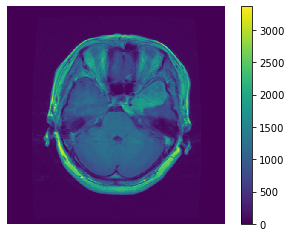

(512, 512)


In [3]:
plt.imshow(X[0])
plt.axis('off')
plt.colorbar()
plt.show()
print(X[0].shape)

In [4]:
X = np.array(X)
y = np.array(y)
X_train, X_aux, y_train, y_aux = train_test_split(X, y, test_size=0.30, random_state=6)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.50, random_state=7)

# Reshape data.
X_train = X_train.reshape((len(X_train),512,512,1))
X_test = X_test.reshape((len(X_test),512,512,1))
print(X_test.shape)
print(X_train.shape)

(453, 512, 512, 1)
(2113, 512, 512, 1)


# Primer Modelo CNN1

In [5]:
tf.keras.backend.clear_session()

# Model
cnn_model1 = tf.keras.Sequential()

# convolution layers
cnn_model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
cnn_model1.add(MaxPooling2D((4, 4)))

cnn_model1.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model1.add(MaxPooling2D((4, 4)))

# NN layers
cnn_model1.add(Flatten())
cnn_model1.add(Dense(64, activation='relu'))
cnn_model1.add(Dense(3))

cnn_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30752)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1968192   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

In [6]:
# Epochs
epochs = 5

# Compile
cnn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit
tini = time.time()
history1 = cnn_model1.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1)
tfin = time.time()

print('Training time: {}'.format((tfin - tini) / 60))

Epoch 1/5
67/67 [==============================] - 315s 5s/step - loss: 150.1091 - accuracy: 0.6148 - val_loss: 0.7240 - val_accuracy: 0.7152
Epoch 2/5
67/67 [==============================] - 289s 4s/step - loss: 0.5708 - accuracy: 0.7454 - val_loss: 0.5296 - val_accuracy: 0.7969
Epoch 3/5
67/67 [==============================] - 318s 5s/step - loss: 0.4307 - accuracy: 0.8235 - val_loss: 0.4660 - val_accuracy: 0.8190
Epoch 4/5
67/67 [==============================] - 308s 5s/step - loss: 0.3667 - accuracy: 0.8656 - val_loss: 0.4090 - val_accuracy: 0.8389
Epoch 5/5
67/67 [==============================] - 302s 5s/step - loss: 0.3067 - accuracy: 0.8911 - val_loss: 0.3700 - val_accuracy: 0.8499
Training time: 26.3594730536143


# Segundo modelo CNN2: más convolution layers

In [7]:

# Model
cnn_model2 = tf.keras.Sequential()

# More convolution layers -> less parameters.
cnn_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
cnn_model2.add(MaxPooling2D((4, 4)))

cnn_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
cnn_model2.add(MaxPooling2D((4, 4)))

cnn_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
cnn_model2.add(MaxPooling2D((4, 4)))

cnn_model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
cnn_model2.add(MaxPooling2D((4, 4)))

# Estructura de NN
cnn_model2.add(Flatten())
cnn_model2.add(Dense(64, activation='relu'))
cnn_model2.add(Dense(3))

cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)         

In [8]:

# Compile
cnn_model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit
tini = time.time()
history2 = cnn_model2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)
tfin = time.time()

print('Training time: {}'.format((tfin - tini) / 60))

Epoch 1/5
67/67 [==============================] - 308s 5s/step - loss: 10.5646 - accuracy: 0.5883 - val_loss: 2.2560 - val_accuracy: 0.6689
Epoch 2/5
67/67 [==============================] - 302s 5s/step - loss: 1.5315 - accuracy: 0.6720 - val_loss: 1.5294 - val_accuracy: 0.6932
Epoch 3/5
67/67 [==============================] - 305s 5s/step - loss: 1.0142 - accuracy: 0.6895 - val_loss: 1.0607 - val_accuracy: 0.7130
Epoch 4/5
67/67 [==============================] - 305s 5s/step - loss: 0.8509 - accuracy: 0.7104 - val_loss: 0.8216 - val_accuracy: 0.6821
Epoch 5/5
67/67 [==============================] - 308s 5s/step - loss: 0.7246 - accuracy: 0.7336 - val_loss: 1.1404 - val_accuracy: 0.7086
Training time: 25.877350517114003


# Tercer modelo CNN3: menos convolution layers

Max pooling más grande

In [9]:
# Model
cnn_model3 = tf.keras.Sequential()

# More convolution layers -> less parameters.
cnn_model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))

# Bigger pooling in order to not over increase parameters.
# Se cambió a (4,4), antes estaba en (5,5)
cnn_model3.add(MaxPooling2D((4, 4)))

# Estructura de NN
cnn_model3.add(Flatten())
cnn_model3.add(Dense(64, activation='relu'))
cnn_model3.add(Dense(3))

cnn_model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                33032256  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 33,032,771
Trainable params: 33,032,771
Non-trainable params: 0
_________________________________________________________________


In [10]:

# Compile
cnn_model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fit
tini = time.time()
history3 = cnn_model3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)
tfin = time.time()

print('Training time: {}'.format((tfin - tini) / 60))

Epoch 1/5
67/67 [==============================] - 276s 4s/step - loss: 2768.7917 - accuracy: 0.4236 - val_loss: 2.0195 - val_accuracy: 0.3885
Epoch 2/5
67/67 [==============================] - 286s 4s/step - loss: 1.1868 - accuracy: 0.3824 - val_loss: 1.0913 - val_accuracy: 0.5055
Epoch 3/5
67/67 [==============================] - 294s 4s/step - loss: 1.0881 - accuracy: 0.4666 - val_loss: 1.0810 - val_accuracy: 0.5055
Epoch 4/5
67/67 [==============================] - 292s 4s/step - loss: 1.0807 - accuracy: 0.4666 - val_loss: 1.0723 - val_accuracy: 0.5055
Epoch 5/5
67/67 [==============================] - 288s 4s/step - loss: 1.0752 - accuracy: 0.4666 - val_loss: 1.0655 - val_accuracy: 0.5055
Training time: 24.293479029337565


# Print info.

In [11]:
n_epochs = 5
acc = []
acc.append([history1.history['val_accuracy'][n_epochs - 1], history1.history['accuracy'][n_epochs - 1]])
acc.append([history2.history['val_accuracy'][n_epochs - 1], history2.history['accuracy'][n_epochs - 1]])
acc.append([history3.history['val_accuracy'][n_epochs - 1], history3.history['accuracy'][n_epochs - 1]])
for i in range(3):
    print('Model CNN{}:'.format(i + 1))
    print('Test acc: {}, Train acc: {}'.format(acc[i][0], acc[i][1]))
    print('---------------------------------------------------------------')

Model CNN1:
Test acc: 0.8498896360397339, Train acc: 0.8911499977111816
---------------------------------------------------------------
Model CNN2:
Test acc: 0.7086092829704285, Train acc: 0.7335541844367981
---------------------------------------------------------------
Model CNN3:
Test acc: 0.5055187344551086, Train acc: 0.4666351079940796
---------------------------------------------------------------


# Plot comparativo

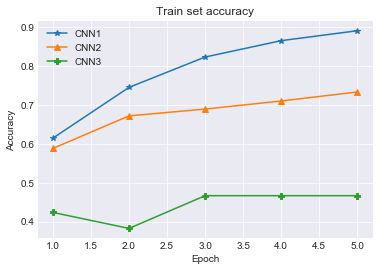

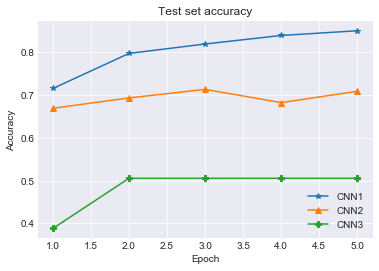

In [12]:
plt.style.use('seaborn-darkgrid')
x = [1, 2, 3, 4, 5]
####################################### Train data ####################################### 
plt.plot(x, history1.history['accuracy'], '*-', label='CNN1')
plt.plot(x, history2.history['accuracy'], '^-', label='CNN2')
plt.plot(x, history3.history['accuracy'], 'P-', label='CNN3')
plt.title('Train set accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('imgs/train_accuracy_cnn_epochs{}'.format(n_epochs))
plt.show()
####################################### Test data ####################################### 
plt.plot(x, history1.history['val_accuracy'], '*-', label='CNN1')
plt.plot(x, history2.history['val_accuracy'], '^-', label='CNN2')
plt.plot(x, history3.history['val_accuracy'], 'P-', label='CNN3')
plt.title('Test set accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('imgs/test_accuracy_cnn_epochs{}'.format(n_epochs))
plt.show()